<a href="https://www.kaggle.com/code/syerramilli/ps4e10-xgboost-optuna?scriptVersionId=199744757" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction


The goal of this classification task is to predict whether an applicant should be approved for a loan or not based on relevant features. In this notebook, we will perform some exploratory data analysis, and then train and tune a XGBoost classification model.


In [1]:
%%capture
!pip install botorch optuna-integration
!pip install --upgrade seaborn # upgrading to > v0.13 removes 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import optuna
from optuna.integration.botorch import BoTorchSampler

import warnings
import joblib
from pathlib import Path
from typing import Dict, Tuple, Union

plt.rcParams.update(**{'figure.dpi': 150})
plt.style.use('ggplot')

## Load and inspect the data

In [3]:
path = Path('/kaggle/input/playground-series-s4e10/')
train = pd.read_csv(path / 'train.csv', index_col='id')
test = pd.read_csv(path / 'test.csv', index_col='id')

In [4]:
# Shape of data
print(f'Training data shape: {train.shape}')
print(f'Testing data shape: {test.shape}')

Training data shape: (58645, 12)
Testing data shape: (39098, 11)


In [5]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


## Exploratory Data Analysis

### Missing values 

We begin by checking for missing values in the dataset. There appear to be no missing values in the dataset.

In [6]:
def filter_greater_than(s: pd.Series, threshold: float=0.0) -> pd.Series:
    return s[s > threshold]

missing_perc = train.isna().sum().pipe(filter_greater_than, 0)
missing_perc

Series([], dtype: int64)

### Target distribution

The target variable is the `loan_status`, which is 1 if the application was approved for a loan or 0 otherwise. Less than 15% of the applicants in the training data were approved. This is clearly an imbalanced classification problem. 

In [7]:
train['loan_status'].value_counts(normalize=True).sort_index()

loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64

### Numerical feature analysis

In [8]:
numerical_columns = train.select_dtypes(include=['number']).columns.tolist()[:-1]
len(numerical_columns)

7

From the Spearman rank correlations among the numerical features, there are two pairs of highly correlated features (both positive)
1. age and credit history length 
2. `loan_amnt` and `loan_percent_income`

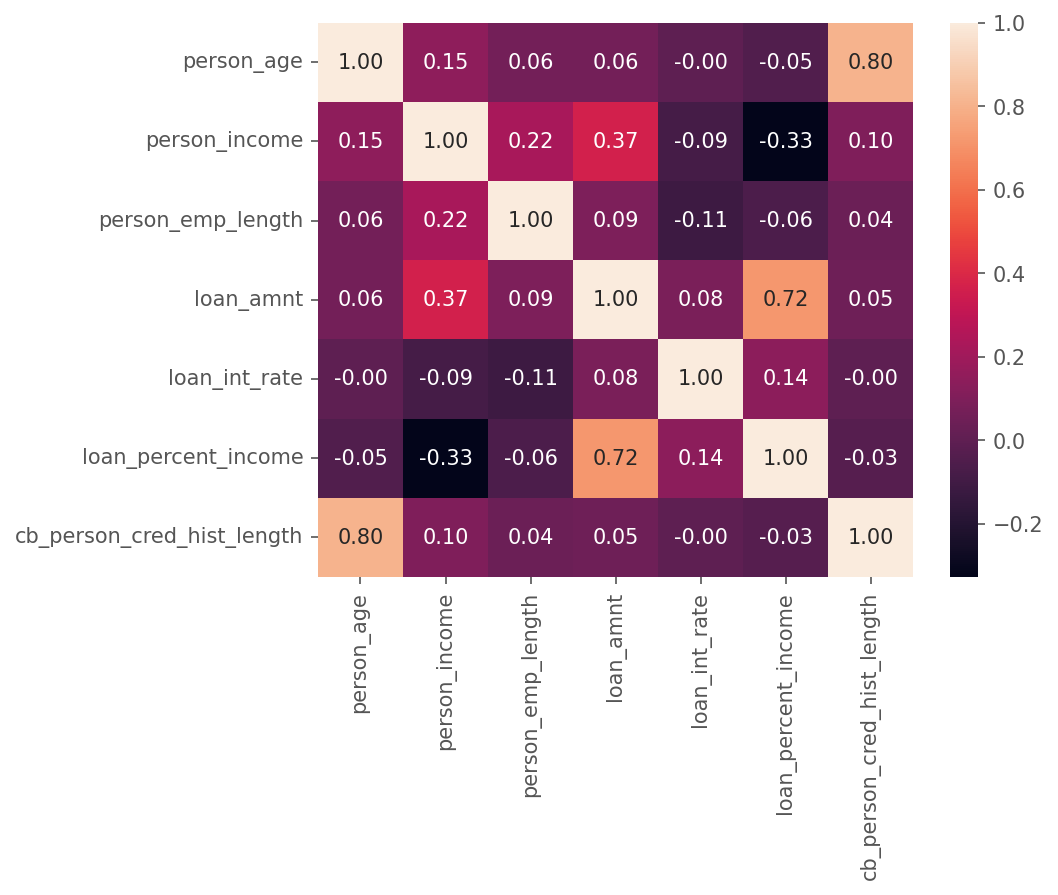

In [9]:
_ = sns.heatmap(train[numerical_columns].corr(method='spearman'), annot=True, fmt='.2f')

Analyzing the boxplot below, we observe that the distributions of `loan_amnt`, `loan_int_rate`, and `loan_percent_income` differ between approved and unapproved loans (especially the latter two). Specifically, the quantile values for both variables are higher among approved loans compared to unapproved loans.

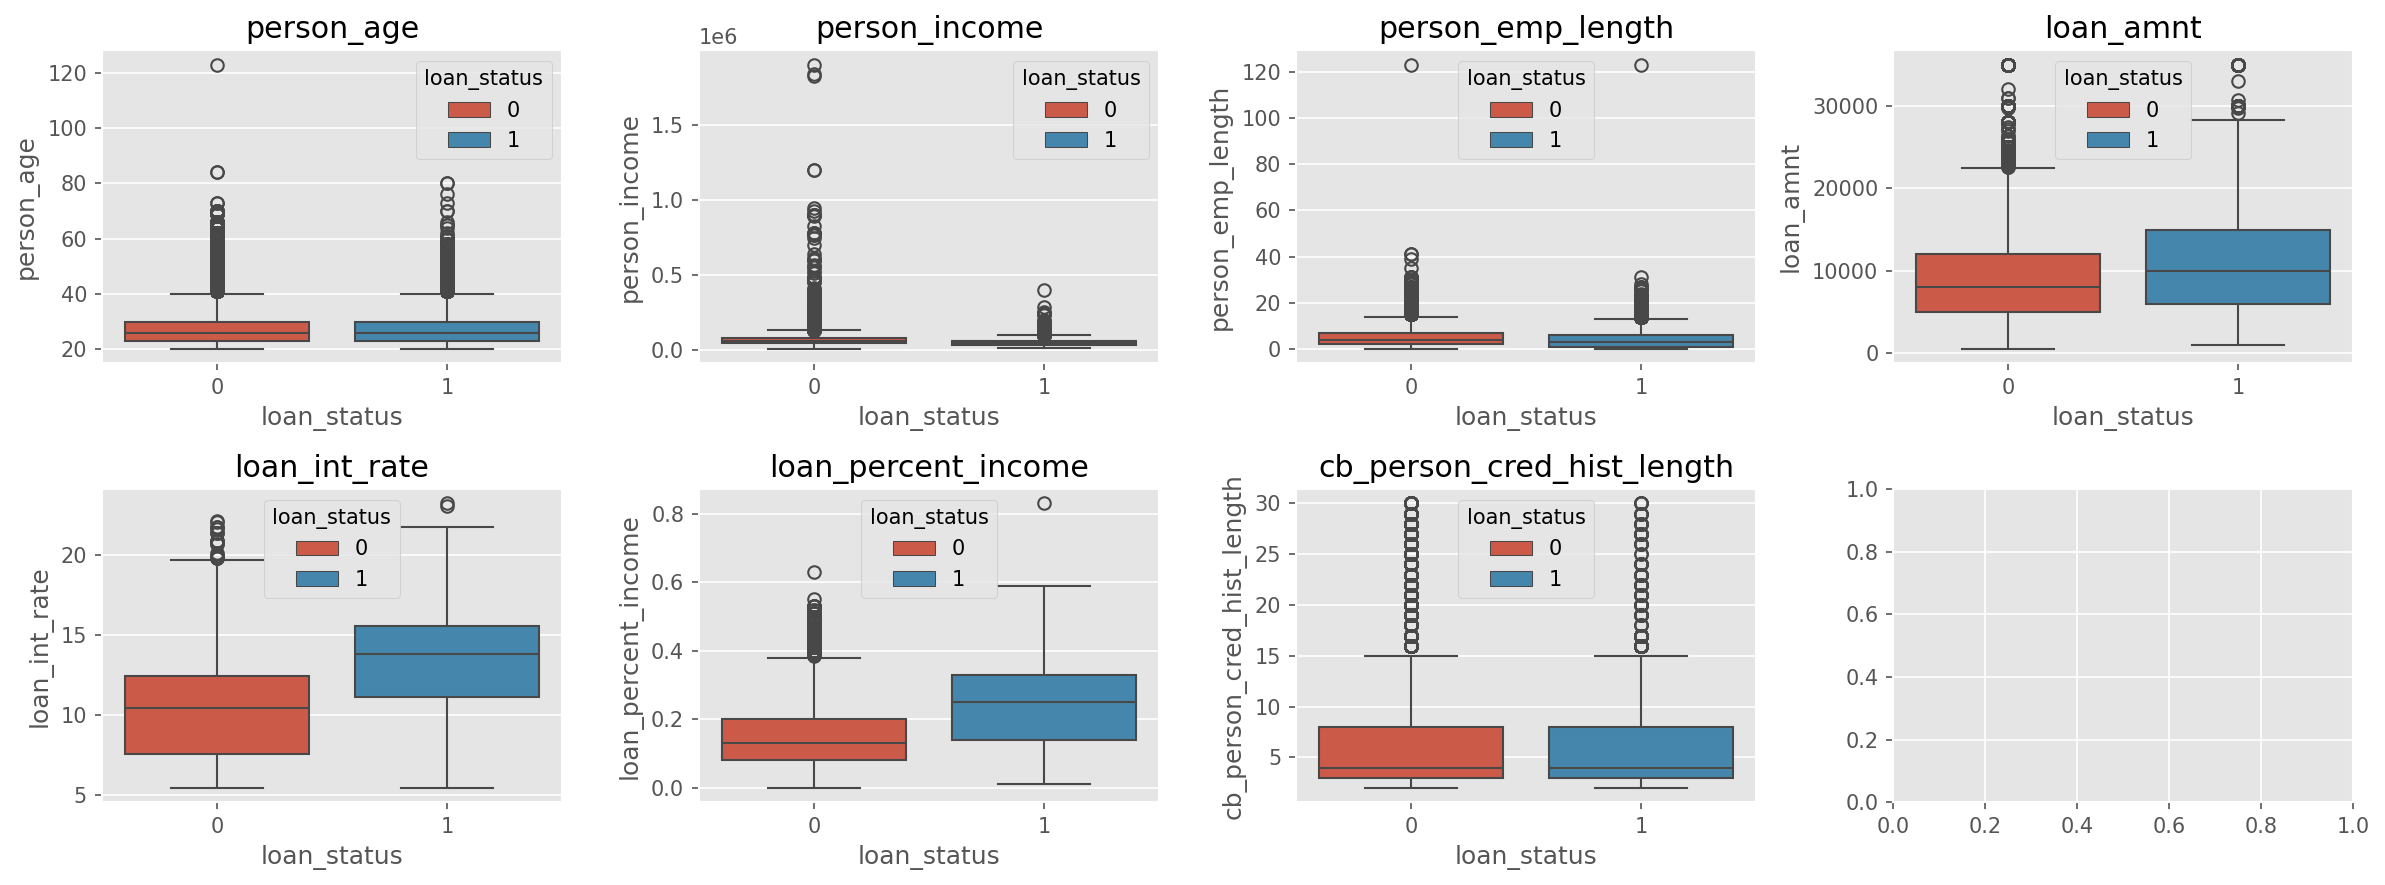

In [10]:
n_rows, n_cols = 2, 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(numerical_columns):
    row, col = divmod(i, n_cols)
    _ = sns.boxplot(data=train, y=column, x='loan_status', hue='loan_status', ax=axs[row, col])
    _ = axs[row,col].set_title(column)

fig.tight_layout()

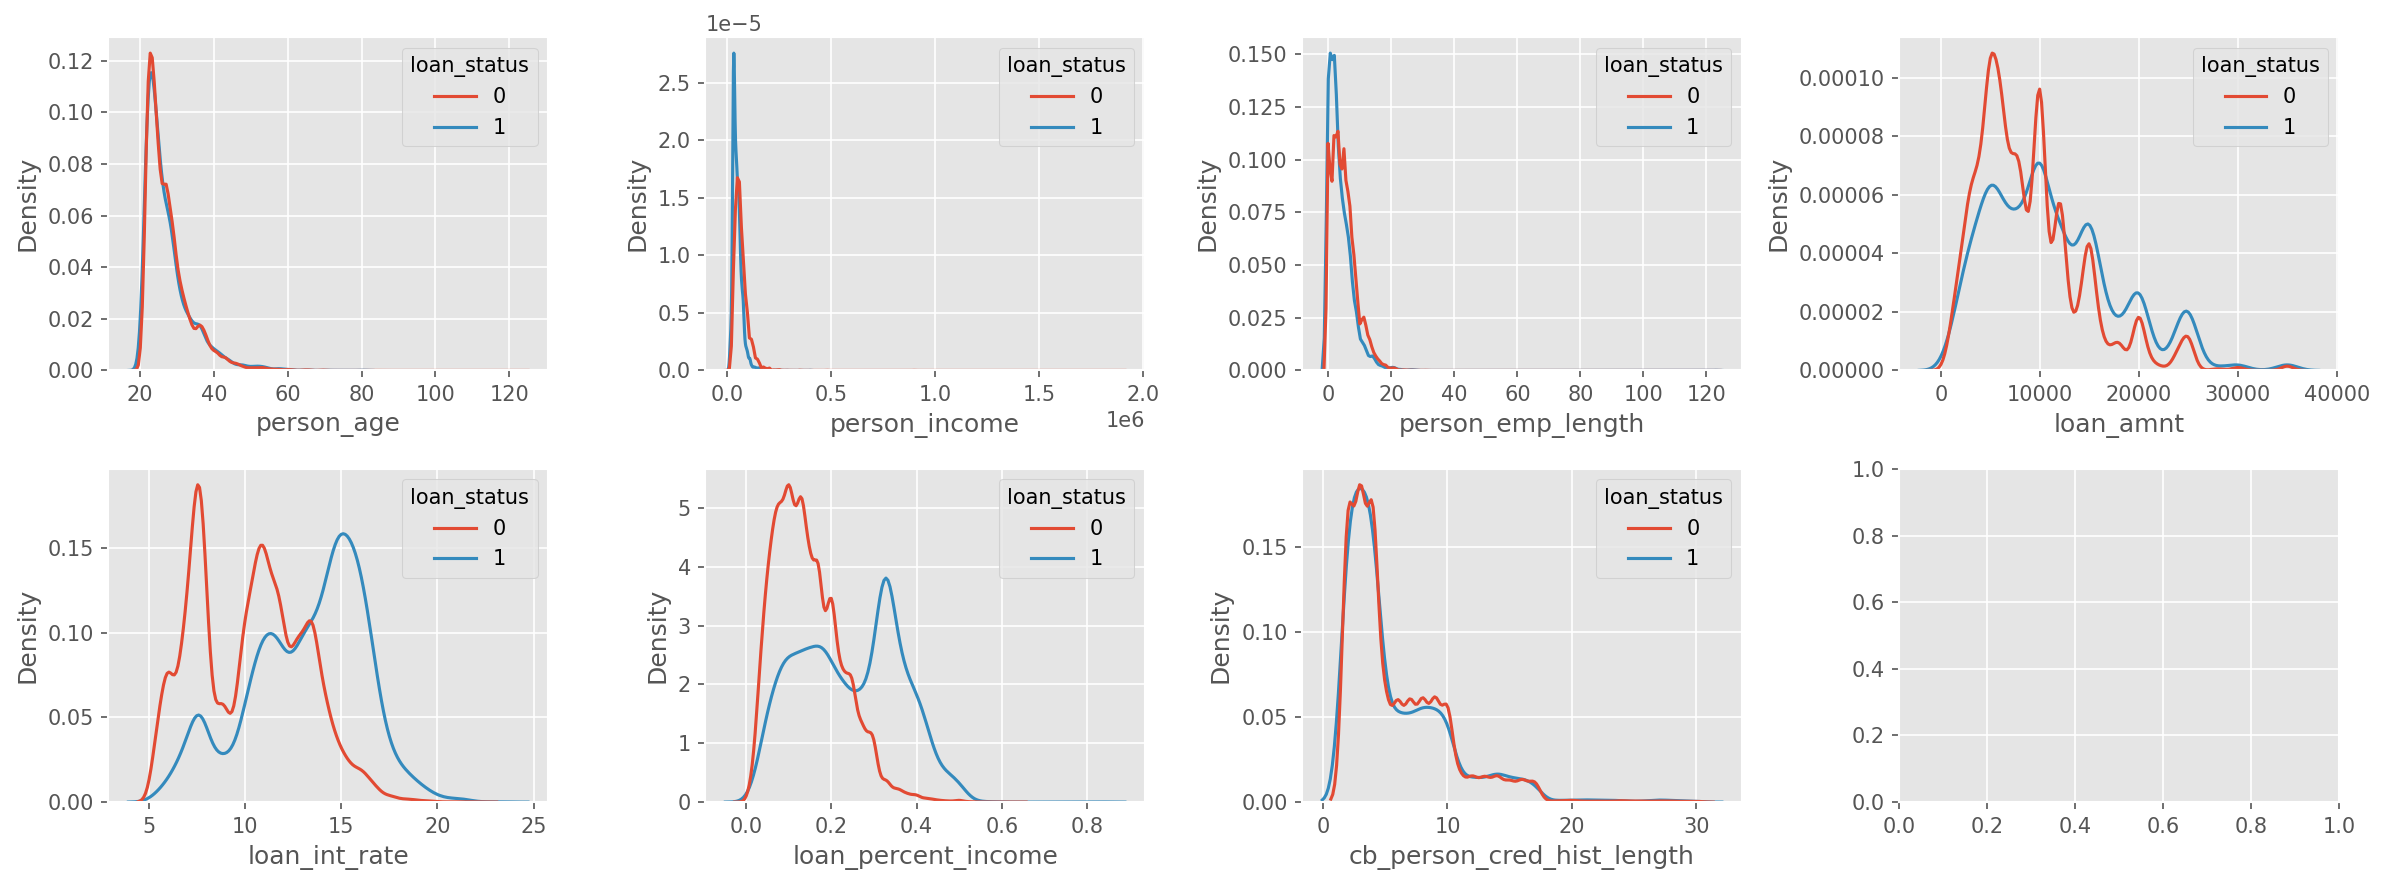

In [11]:
n_rows, n_cols = 2, 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(numerical_columns):
    row, col = divmod(i, n_cols)
    _ = sns.kdeplot(data=train, x=column, hue='loan_status', common_norm=False, ax=axs[row, col])

fig.tight_layout()

### Categorical features

In [12]:
categorical_columns = train.select_dtypes(exclude=['number']).columns.tolist()
n_categories = [train[column].nunique() for column in categorical_columns]
print(categorical_columns)

['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


For `person_home_ownership` and `loan_grade`, there are a few categories which have very few observations.

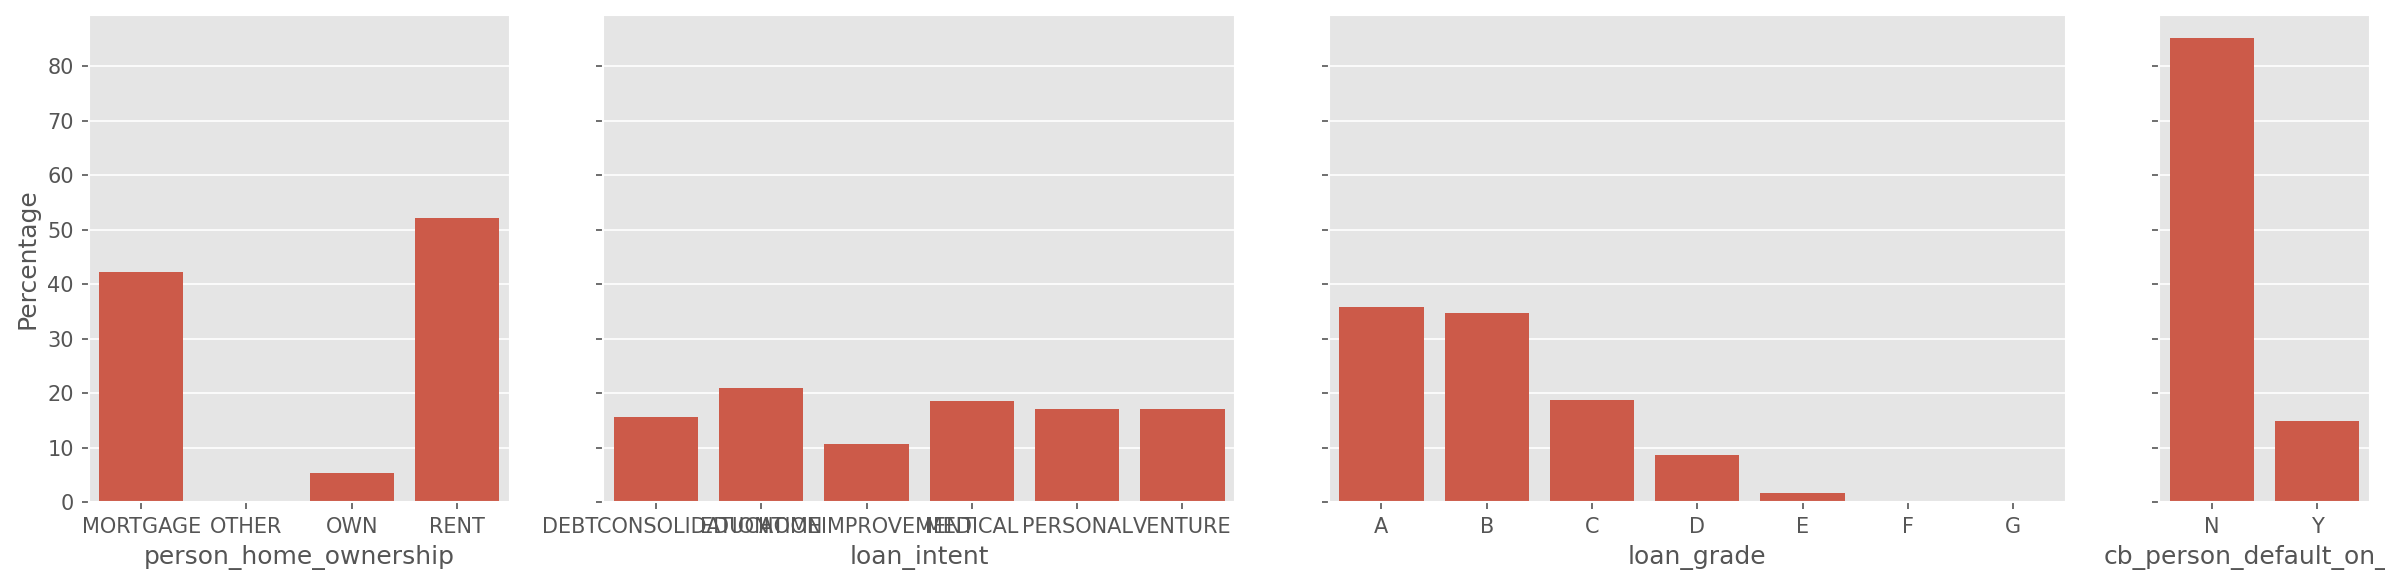

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), gridspec_kw={'width_ratios': n_categories}, sharey=True)

for i, column in enumerate(categorical_columns):
    # Calculate percentages and sort categories by name
    counts = train[column].value_counts(normalize=True).sort_index() * 100
    df = counts.reset_index()
    df.columns = [column, 'percentage']
    
    # Plot the percentages
    sns.barplot(data=df, x=column, y='percentage', ax=axs[i], order=df[column])
    
    # Set y-axis label to 'Percentage'
    axs[i].set_ylabel('Percentage')

fig.tight_layout()


For `person_home_ownership`, we will merge 'OWN' with 'MORTAGE' and 'OTHER' with 'RENT', and convert it into a binary valued column.

In [14]:
(
    train.groupby('person_home_ownership')
    [['loan_status', 'loan_int_rate']]
    .mean()
    .sort_values('loan_status')
)

,loan_status,loan_int_rate
person_home_ownership,,
OWN,0.013703,10.707307
MORTGAGE,0.059741,9.958439
OTHER,0.168539,11.561348
RENT,0.222560,11.256036


The `loan_grade` likely refers to the default risk of the loan - the greater the risk, the higher the interest rate. What we also see is that the higher interest rate groups (which are much fewer in applications) are much more likely to be approved.  We will group grades 'D', 'E', 'F' , 'G' as 'D+'.

In [15]:
(
    train.groupby('loan_grade')
    [['loan_status', 'loan_int_rate']]
    .mean()
    .sort_values('loan_int_rate')
)

,loan_status,loan_int_rate
loan_grade,,
A,0.049180,7.335176
B,0.102304,11.034733
C,0.135375,13.510343
D,0.593564,15.404599
E,0.625372,16.930961
F,0.610738,18.610940
G,0.818182,20.327576


In [16]:
(
    train.groupby('loan_intent')
    [['loan_status', 'loan_int_rate']]
    .mean()
    .sort_values('loan_status')
)

,loan_status,loan_int_rate
loan_intent,,
VENTURE,0.092798,10.604354
EDUCATION,0.107734,10.681510
PERSONAL,0.132788,10.607075
HOMEIMPROVEMENT,0.173726,10.881809
MEDICAL,0.178251,10.742830
DEBTCONSOLIDATION,0.189313,10.613230


Applicants having a default on file have a higher approval rate - albeit not much difference in the interest rates.

In [17]:
(
    train.groupby('cb_person_default_on_file')
    [['loan_status', 'loan_int_rate']]
    .mean()
    .sort_values('loan_status')
)

,loan_status,loan_int_rate
cb_person_default_on_file,,
N,0.115111,10.042178
Y,0.298897,14.326300


## Prepare data

In [18]:
X = train.drop(columns = ['loan_status'])
y = train['loan_status'].values

In [19]:
# transform categorical valued columns
def feat_eng(df: pd.DataFrame) -> None:
    
    # transform person_home_ownership
    df['person_home_ownership'] = df['person_home_ownership'].map({
        'OWN': 1, 'MORTGAGE': 1,
        'RENT': 0, 'OTHER': 0
    })
    
    # transform loan grades
    df['loan_grade'] = df['loan_grade'].apply(lambda x: x if x in ['A', 'B', 'C'] else 'D+')
    
    # binarize cb_person_default_on_file
    df['cb_person_default_on_file'] = 1 * (df['cb_person_default_on_file']  == 'Y')
    

feat_eng(X)

In [20]:
categorical_columns = X.select_dtypes(exclude=['number']).columns.tolist()
print(categorical_columns)

['loan_intent', 'loan_grade']


## XGBoost model

In [21]:
def return_estimator(params:Dict = {}):
    return Pipeline([
        (
            'preproc', 
            ColumnTransformer(
                transformers = [('ohe', OneHotEncoder(sparse_output=False), categorical_columns)],
                remainder='passthrough',
                sparse_threshold=0
            ).set_output(transform='pandas')
        ),
        ('xgb', XGBClassifier(tree_method='hist', **params))
    ])


## Tuning hyperparameters via optuna

In [22]:
def fit_and_test_model(
    X: pd.DataFrame, y: np.ndarray,
    train_index: np.ndarray, valid_index: np.ndarray,
    params: Dict[str, Union[str, int, float]] = {}
) -> float:
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    model = return_estimator(params)
    
    _ = model.fit(X_train, y_train)
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_valid_pred)

def optuna_objective(trial: optuna.trial.Trial) -> float:
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.75, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 12, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 100, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 1000, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 7, log=True)
    }

    cv_auc = [
        fit_and_test_model(X, y, train_index, valid_index, params) \
            for train_index, valid_index in StratifiedKFold(
                n_splits=5, shuffle=True, random_state=0
            ).split(X, y)
    ]
    return np.mean(cv_auc)


with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=optuna.exceptions.ExperimentalWarning)
    warnings.simplefilter(action="ignore", category=FutureWarning)

    study = optuna.create_study(
        direction='maximize', 
        study_name='xgboost',
        sampler=BoTorchSampler(n_startup_trials=10, seed=2)
    )

    # run optuna for a maximum of 120 trials or 1 hr wall clock
    study.optimize(optuna_objective, timeout=3600, n_trials=120)
    
    
# save the runs
_ = joblib.dump(study, 'xgboost_auc.pkl')


[I 2024-10-06 13:27:33,980] A new study created in memory with name: xgboost
[I 2024-10-06 13:27:38,069] Trial 0 finished with value: 0.9140579086384344 and parameters: {'n_estimators': 219, 'learning_rate': 0.0011872426915762793, 'max_depth': 3, 'subsample': 0.7176611963091384, 'colsample_bytree': 0.4783310218787401, 'reg_alpha': 9.397522821096242e-06, 'reg_lambda': 6.94764639026943e-07, 'gamma': 0.01558510252222362, 'min_child_weight': 7.924356787008142, 'scale_pos_weight': 1.6807193775189202}. Best is trial 0 with value: 0.9140579086384344.
[I 2024-10-06 13:27:45,231] Trial 1 finished with value: 0.9103270702853166 and parameters: {'n_estimators': 412, 'learning_rate': 0.033213599009341066, 'max_depth': 1, 'subsample': 0.7567890606328732, 'colsample_bytree': 0.2659958790822238, 'reg_alpha': 0.11695433673868773, 'reg_lambda': 0.4850400877042276, 'gamma': 0.0008757262618707403, 'min_child_weight': 346.4850144870169, 'scale_pos_weight': 1.1676380434102045}. Best is trial 0 with value: 

In [23]:
fig = optuna.visualization.plot_optimization_history(study, target_name='CV AUC')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

In [24]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(
    autosize=True,
    width=800,
    height=400
)
fig.show()

In [25]:
results = study.trials_dataframe(attrs=('number','value', 'duration', 'params'))
results = results.rename(columns={'value':'AUC'})
results['duration'] = results['duration']/np.timedelta64(1, 's')
results = results.sort_values(by='AUC',ascending=False)
results.to_csv('cv_AUC_history.csv',index=False)

The best hyperparameters are as follows:

In [26]:
study.best_params

{'n_estimators': 1419,
 'learning_rate': 0.07915219494459072,
 'max_depth': 3,
 'subsample': 0.9999999999999999,
 'colsample_bytree': 0.8813854426101193,
 'reg_alpha': 9.999999999999998,
 'reg_lambda': 4.109989254435594e-06,
 'gamma': 4.821640848376221e-07,
 'min_child_weight': 4.149289418028017,
 'scale_pos_weight': 4.423635548267329}

## Final model

In [27]:
model = return_estimator(study.best_params)
_ = model.fit(X, y)

# save model
_ = joblib.dump(model, 'xgboost_loan_approval.pkl')

## Test predictions and submission

In [28]:
# apply feature engineering 
feat_eng(test)

submission = pd.DataFrame({
    'id': test.index.tolist(),
    'loan_status': model.predict_proba(test)[:, 1]
})

# save submission
submission.to_csv('submission.csv', index=False)

In [29]:
# check submission output
submission.head(5)

,id,loan_status
0,58645,0.998863
1,58646,0.081457
2,58647,0.846568
3,58648,0.029543
4,58649,0.079226
